In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
tick_data = pd.read_csv("/Users/katyaluchette/Downloads/tick_bite_diseases.csv")
tick_data.head()

,Year,Month,COUNT,Disease
0,2016,January,534,Lyme disease
1,2016,January,30,Anaplasmosis
2,2016,January,53,Spotted Fever Rickettsiosis
3,2016,January,11,Babesiosis
4,2016,January,11,Ehrlichia chaffeensis ehrlichiosis


In [10]:
tick_data['Date'] = pd.to_datetime(tick_data['Year'].astype(str) + ' ' + tick_data['Month'], format='%Y %B')
tick_data = tick_data.drop(columns=['Year'])
tick_data = tick_data.drop(columns=['Month'])
tick_data.head()

,COUNT,Disease,Date
0,534,Lyme disease,2016-01-01
1,30,Anaplasmosis,2016-01-01
2,53,Spotted Fever Rickettsiosis,2016-01-01
3,11,Babesiosis,2016-01-01
4,11,Ehrlichia chaffeensis ehrlichiosis,2016-01-01


In [12]:
print(tick_data["Disease"].unique())

['Lyme disease' 'Anaplasmosis' 'Spotted Fever Rickettsiosis' 'Babesiosis'
 'Ehrlichia chaffeensis ehrlichiosis' 'Tularemia']


In [14]:
lyme_disease = tick_data[tick_data["Disease"] == "Lyme disease"]
lyme_disease.head()

,COUNT,Disease,Date
0,534,Lyme disease,2016-01-01
6,503,Lyme disease,2016-02-01
12,771,Lyme disease,2016-03-01
18,1009,Lyme disease,2016-04-01
24,2168,Lyme disease,2016-05-01


In [16]:
lyme_disease_rate = lyme_disease[['Date', 'COUNT']]
lyme_disease_rate.set_index('Date', inplace = True)
lyme_diease_rate = lyme_disease_rate.dropna()
lyme_disease_rate.head()

,COUNT
Date,
2016-01-01,534
2016-02-01,503
2016-03-01,771
2016-04-01,1009
2016-05-01,2168


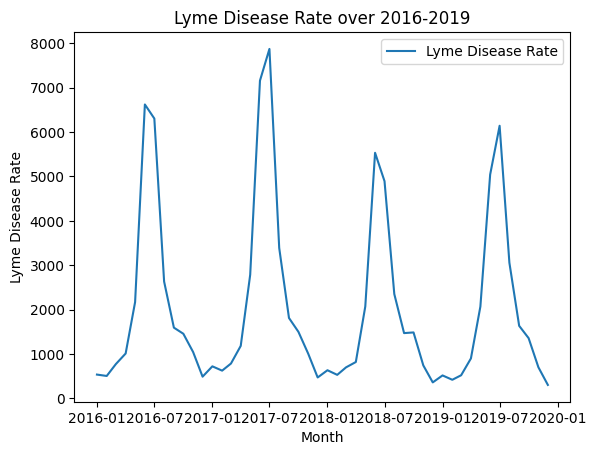

In [18]:
plt.plot(lyme_disease_rate['COUNT'], label='Lyme Disease Rate')
plt.xlabel('Month')
plt.ylabel('Lyme Disease Rate')
plt.legend()
plt.title('Lyme Disease Rate over 2016-2019')
plt.show();

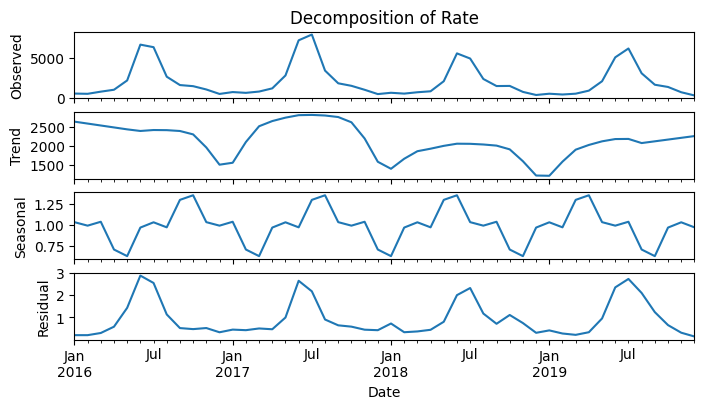

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp1 = seasonal_decompose(lyme_disease_rate['COUNT'], period=10, model='multiplicative', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of Rate')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

In [41]:
for i in range(1, 11):
    lyme_disease_rate[f'Lag {i}'] = lyme_diease_rate['COUNT'].shift(i)

lyme_disease_rate = lyme_disease_rate.dropna()
lyme_disease_rate.head()

,COUNT,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,Lag 10
Date,,,,,,,,,,,
2016-11-01,1042,1454.0,1592.0,2631.0,6305.0,6622.0,2168.0,1009.0,771.0,503.0,534.0
2016-12-01,487,1042.0,1454.0,1592.0,2631.0,6305.0,6622.0,2168.0,1009.0,771.0,503.0
2017-01-01,720,487.0,1042.0,1454.0,1592.0,2631.0,6305.0,6622.0,2168.0,1009.0,771.0
2017-02-01,623,720.0,487.0,1042.0,1454.0,1592.0,2631.0,6305.0,6622.0,2168.0,1009.0
2017-03-01,783,623.0,720.0,487.0,1042.0,1454.0,1592.0,2631.0,6305.0,6622.0,2168.0


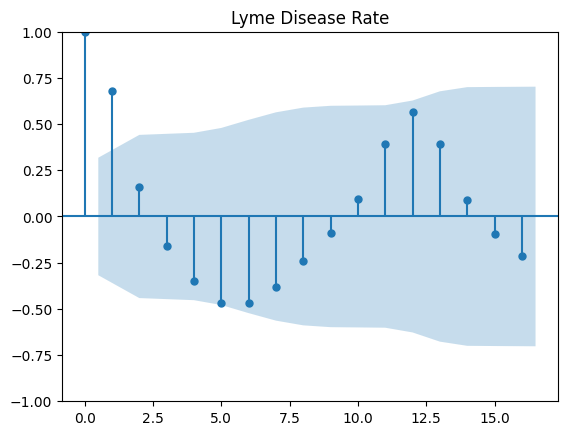

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = lyme_disease_rate['COUNT']
plot_acf(series, title = 'Lyme Disease Rate')
plt.show();

In [43]:
train_size = int(.8 * len(lyme_disease_rate))
train_data = lyme_disease_rate[:train_size]
test_data = lyme_disease_rate[train_size:]

# put the y feature (the current SO9) in arrays
y_train = np.array(train_data['COUNT']).reshape(-1,1)
y_test = np.array(test_data['COUNT']).reshape(-1,1)

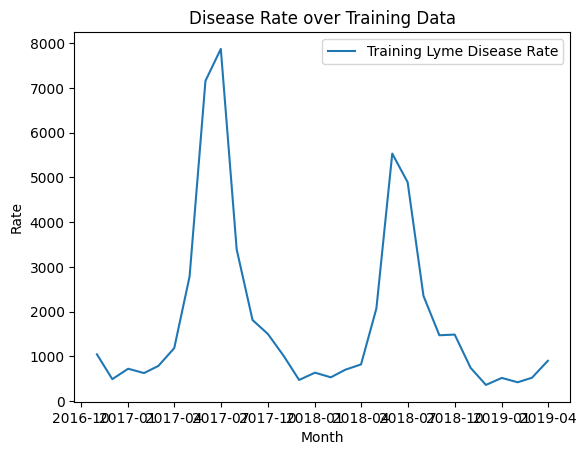

In [44]:
plt.plot(train_data['COUNT'], label='Training Lyme Disease Rate')
plt.xlabel('Month')
plt.ylabel('Rate')
plt.legend()
plt.title('Disease Rate over Training Data')
plt.show();

In [47]:
lyme_disease_rate['COUNT'].corr(lyme_disease_rate['COUNT'].shift(1))

0.6897453933088056

In [59]:
X_train = np.array(train_data['Lag 2']).reshape(-1,1)

print(X_train.shape)
print(y_train.shape)

(30, 1)
(30, 1)


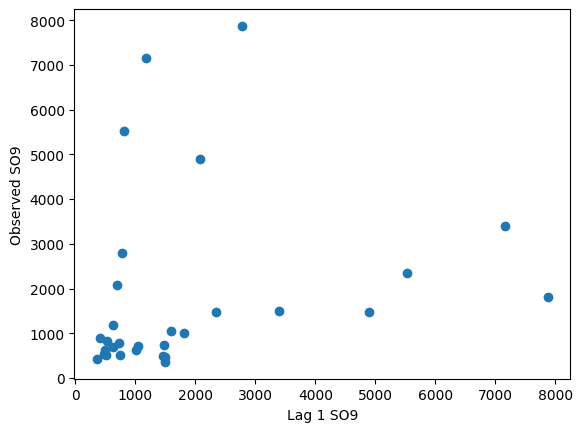

In [60]:
plt.scatter(x = X_train, y = y_train)
plt.xlabel('Lag 1 SO9')
plt.ylabel('Observed SO9')
plt.show();

In [61]:
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))
w

array([[0.58097629]])

In [62]:
y_pred = []
start = X_train[len(X_train)-1].reshape(-1,1)
for i in range(len(y_test)):
    y_pred.append(w.T.dot(start).flatten()[0])
    start = y_pred[i].reshape(-1,1)

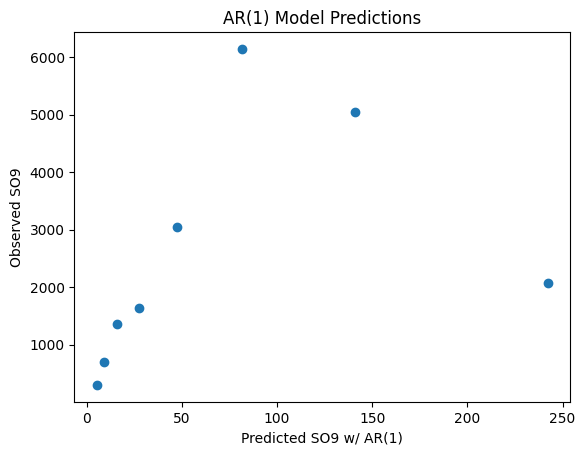

In [63]:
plt.scatter(x = y_pred, y = y_test)
plt.xlabel('Predicted SO9 w/ AR(1)')
plt.ylabel('Observed SO9')
plt.title('AR(1) Model Predictions')
plt.show();

In [64]:
pred_data = pd.DataFrame({'Date': test_data.index, 'pred COUNT': y_pred})
pred_data.set_index('Date', inplace = True)
pred_data.head()

,pred COUNT
Date,
2019-05-01,242.267111
2019-06-01,140.751446
2019-07-01,81.773252
2019-08-01,47.508320
2019-09-01,27.601208


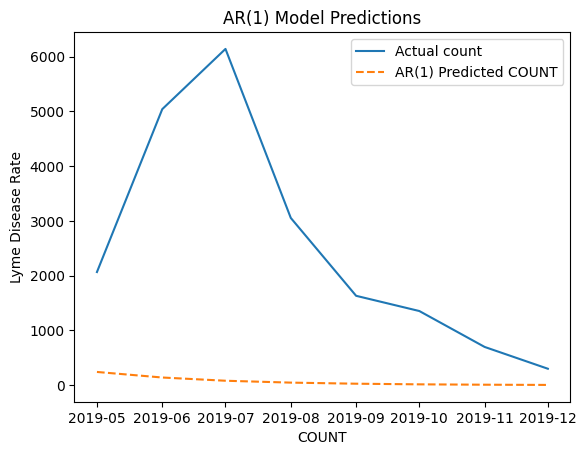

In [65]:
plt.plot(test_data['COUNT'], label = 'Actual count')
plt.plot(pred_data['pred COUNT'], label = 'AR(1) Predicted COUNT', linestyle = '--')
plt.xlabel('COUNT')
plt.ylabel('Lyme Disease Rate')
plt.legend()
plt.title('AR(1) Model Predictions')
plt.show();